<a href="https://colab.research.google.com/github/dpshepherd/PHY333_S2022/blob/main/Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using python to analyze frequency response of RLC filters

Goals for this analysis:
1. Fit output channel (B) from RLC frequency built in Lab #4

## Setup python packages

### Import numpy for calculations,  matplotlib for plotting, and scipy for data fitting

In [ ]:
pip install scipy --upgrade

In [ ]:
import numpy as np # for math operations
import matplotlib.pyplot as plt # for plotting data
from scipy.optimize import curve_fit # for fitting data
import pandas as pd # for importing data files from picoScope software

## Load data from lab 4

#### Data is in a CSV file generated by the picoScope program.

We will use the [pandas](https://pandas.pydata.org/) library to load the data.

Example data can be downloaded [here](https://github.com/dpshepherd/PHY333_S2022/blob/00d82a96d3effd55f756ef95bc81e42928de8adf/Lab2data.zip). You'll need to download it, then unzip it on your local computer. 

Then click the "folder" icon to the left. You can then drag and drop the file into to storage for this Google Colab session. 

Once the file is uploaded, click the right dots to the right of the file and copy the file path.
  

In [ ]:
# paste file path here. Make sure there are quotes around the filename.
file_path = "/content/lab4/Lab 3-1 Sine Sweep_01.csv"

# load the data. Check if the datafile it tab separated or comma separated
if file_path.endswith('.txt'):
  df_data = pd.read_csv(file_path, sep='\t')
elif file_path.endswith('.csv'):
  df_data = pd.read_csv(file_path)

### Inspect loaded data

The data is now formatted as a Pandas "dataframe". This looks somewhat like a spreadsheet.

Notice that the Frequency is in kHz. We will need to be careful about units as we proceed with the analysis.

In [ ]:
df_data

,Frequency,Channel B
0,(kHz),(dBu)
1,0.00000000,-43.89502000
2,0.01192093,-51.13597000
3,0.02384186,-66.46846000
4,0.03576279,-79.88480000
...,...,...
4092,48.76852036,-82.81752000
4093,48.78044128,-82.79883000
4094,48.79236221,-82.51049000
4095,48.80428314,-81.78534000


### Extract data into numpy arrays

We need to get the data out of the Pandas dataframe into numpy arrays for calculations. We will convert to SI units at the same time.

In [ ]:
# remove first row of datafrme to drop cells that contain unit information
df_data_cleaned = df_data.drop(0)
df_data_cleaned["Frequency"] = pd.to_numeric(df_data_cleaned["Frequency"], downcast="float")
df_data_cleaned["Channel B"] = pd.to_numeric(df_data_cleaned["Channel B"], downcast="float")


# extract data
frequency_values = df_data_cleaned['Frequency'].to_numpy(dtype=np.float) * 1e3 # Hz
filter_response = df_data_cleaned['Channel B'].to_numpy(dtype=np.float) # convert to dB

### Plot full frequency response

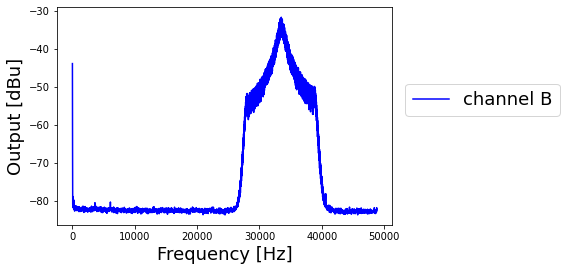

In [ ]:
plt.plot(frequency_values,filter_response,label='channel B',color='b')

plt.xlabel('Frequency [Hz]', fontsize=18)
plt.ylabel('Output [dBu]', fontsize=18)
plt.legend(loc=(1.04,.5),fontsize=18)
plt.show()

### Extract only the frequency window we need

In [ ]:
# extract data between certain frequency
start_frequency = 30.2
end_frequency = 38.0
df_data_cleaned_filtered = df_data_cleaned[df_data_cleaned['Frequency'].between(start_frequency, end_frequency)]

# create arrays
extracted_frequency_values = df_data_cleaned_filtered['Frequency'].to_numpy(dtype=np.float) * 1e3 # Hz
extracted_filter_response = df_data_cleaned_filtered['Channel B'].to_numpy(dtype=np.float) # convert to dB

### Plot filtered frequency response

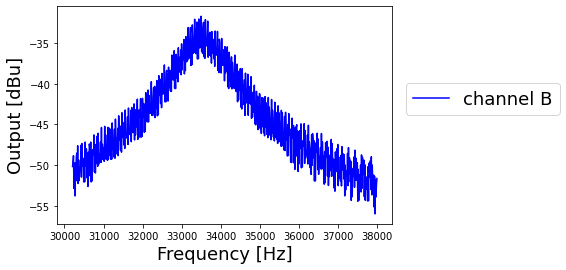

In [ ]:
# plot data
plt.plot(extracted_frequency_values,extracted_filter_response,label='channel B',color='b')

plt.xlabel('Frequency [Hz]', fontsize=18)
plt.ylabel('Output [dBu]', fontsize=18)
plt.legend(loc=(1.04,.5),fontsize=18)
plt.show()

### Create smoothed data by taking rolling average 

In [ ]:
smoothed_windows = df_data_cleaned_filtered.rolling(window=20, min_periods=1,closed='both')
df_smoothed_mean = smoothed_windows.mean()
df_smooth_variance = smoothed_windows.var()

# create arrays
extracted_smoothed_frequency = df_smoothed_mean['Frequency'].to_numpy(dtype=np.float) * 1e3 # Hz
extracted_smoothed_response_mean = df_smoothed_mean['Channel B'].to_numpy(dtype=np.float) # convert to dB
extracted_smoothed_response_var = df_smooth_variance['Channel B'].to_numpy(dtype=np.float) # convert to dB

### Plot smoothed data with error bars



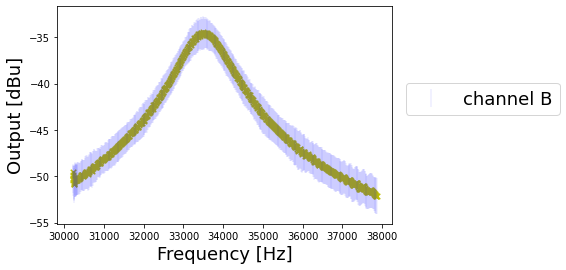

In [ ]:
# plot data
plt.errorbar(x=extracted_smoothed_frequency,y=extracted_smoothed_response_mean,xerr=None,yerr=np.sqrt(extracted_smoothed_response_var),ls='none',label='channel B',ecolor='b',elinewidth=.1)
plt.scatter(extracted_smoothed_frequency, extracted_smoothed_response_mean, s = 30, marker = "x", color = "y")

#plt.plot(extracted_smoothed_values,extracted_smoothed_response,label='channel B',color='b')

plt.xlabel('Frequency [Hz]', fontsize=18)
plt.ylabel('Output [dBu]', fontsize=18)
plt.legend(loc=(1.04,.5),fontsize=18)
plt.show()

## Analysis #1: fit values of individual components using frequency response derived in class

### Create function to fit  data and perform parameter optimization for $\frac{P_{out}}{P_{in}} = \frac{(\omega L)^2}{[R^2(1-\omega^2LC)^2 + (\omega L)^2]}$. Remember that $\omega = 2\pi f$.

In [ ]:
# y = 1/(2*gamma)*(gamma**2)/((x-x_0)**2+gamma**2)
def fit_function_cauchy_lorentzian(frequency_values,A,x_0,gamma):

    model = (gamma**2)/((frequency_values-x_0)**2+gamma**2)
    model = A+20*np.log10(model)

    return model

### Create ODR model and data structures for fitting

In [ ]:
popt, pcov = curve_fit(fit_function_cauchy_lorentzian,
                       xdata=extracted_smoothed_frequency,
                       ydata=extracted_smoothed_response_mean,
                       p0=(0,10e3,1e3))

### Extract results of the fitting

In [ ]:
# Extract fits and uncertainities from fitting program
A = popt[0]
x_0 = popt[1]
gamma = popt[2]

print('Fit results')
print('-----------------')
print('Offset (dBu) = ' + str(np.round(A,2)))
print('Center frequency (kHz)) = ' + str(np.round(x_0/1e3,2)))
print('FWHM (kHz) = ' + str(np.round(gamma/1e3,2)) )

Fit results
-----------------
Offset (dBu) = -36.82
Center frequency (kHz)) = 33.61
FWHM (kHz) = 1.64


### Plot results of fitting.

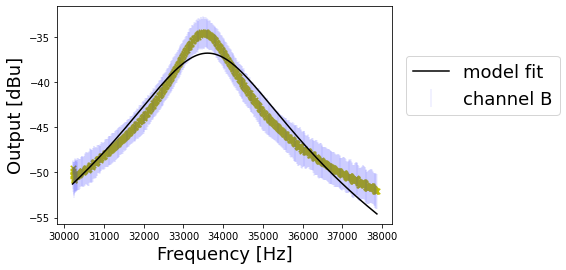

In [ ]:
# plot data
plt.errorbar(x=extracted_smoothed_frequency,y=extracted_smoothed_response_mean,xerr=None,yerr=np.sqrt(extracted_smoothed_response_var),ls='none',label='channel B',ecolor='b',elinewidth=.1)
plt.scatter(extracted_smoothed_frequency, extracted_smoothed_response_mean, s = 30, marker = "x", color = "y")

model_values = fit_function_cauchy_lorentzian(extracted_smoothed_frequency,*popt)

plt.plot(extracted_smoothed_frequency,model_values,label='model fit',color='k')

plt.xlabel('Frequency [Hz]', fontsize=18)
plt.ylabel('Output [dBu]', fontsize=18)
plt.legend(loc=(1.04,.5),fontsize=18)
plt.show()

### Obviously, the fit is not great. I suggest you also fit the other data you took during the lab. Perhaps if we fit the other data that you collect we may get a better fit to the Cauchy-Lorentzian distribution. You can use the same function and code block above. The process is:
1. Determine $\frac{V_{out}}{V_{in}}$ for a $N>10$  frequencies that you measured around the resonant frequency of your circuit
2. Fill the variable belows with your frequencies and $|V_{out}|^2/|V_{in}|^2$.
3. Fit this data with the Cauchy-Lorentzian distribution

### Input your discrete data below. The data I put in below is fake, you need to replace with data from the lab!. 

In [ ]:
frequencies_discrete = [0,
               1000,
               2000,
               3000,
               4000,
               5000,
               6000]
power_ratio_discrete = [0,
               1,
               10,
               100,
               10,
               1,
               0]

### Fit your discrete data

In [ ]:
popt_discrete, pcov = curve_fit(fit_function_cauchy_lorentzian,
                       xdata=frequencies_discrete,
                       ydata=power_ratio_discrete,
                       p0=(0,10e3,1e3))

In [ ]:
# Extract fits and uncertainities from fitting program
A = popt_discrete[0]
x_0 = popt_discrete[1]
gamma = popt_discrete[2]

print('Discrete data fit results')
print('-----------------')
print('Offset (dBu) = ' + str(np.round(A,2)))
print('Center frequency (kHz)) = ' + str(np.round(x_0/1e3,2)))
print('FWHM (kHz) = ' + str(np.round(gamma/1e3,2)) )

### Plot your results for the discrete data

In [ ]:
# plot data
plt.scatter(frequencies_discrete, power_ratio_discrete, s = 30, marker = "x", color = "y")
model_values = fit_function_goal_one(frequencies_discrete,*popt)

plt.plot(frequencies_discrete,model_values,label='model fit',color='k')
plt.xlabel('Frequency [Hz]', fontsize=18)
plt.ylabel('Output [dBu]', fontsize=18)
plt.legend(loc=(1.04,.5),fontsize=18)
plt.show()